In [1]:
#  Import necessary libraries
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
from torch import optim

In [16]:
# Pima dataset

class PimaDataset(Dataset):

    def __init__(self, data):
        self.data = data
           
    def __getitem__(self, index):
        item = self.data.iloc[index].values    
        return (item[0:8].astype(np.float32), item[8].astype(np.int))

    def __len__(self):
        return self.data.shape[0]


    def get_datasets(pima_file, train_ratio=0.60,valid_ratio=0.20,test_ratio=0.20):

        labels = {'class': label_idx}
        df = pd.read_csv(pima_file)
        data=(df-df.mean())/df.std()

        train_df = data.sample(frac=train_ratio, random_state=5)
        validation_df = data.sample(frac=valid_ratio, random_state=5)
        test_df = data.sample(frac=test_ratio, random_state=5)

        return PimaDataset(train_df), PimaDataset(validation_df),PimaDataset(test_df)
    


In [17]:
pima_file = "diabetes.csv"

In [18]:
# Get train, validation and test data
train_ds,validation_ds,test_ds = PimaDataset.get_datasets(pima_file)

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639530  0.847771       0.149543       0.906679 -0.692439  0.203880   
1    -0.844335 -1.122665      -0.160441       0.530556 -0.692439 -0.683976   
2     1.233077  1.942458      -0.263769      -1.287373 -0.692439 -1.102537   
3    -0.844335 -0.997558      -0.160441       0.154433  0.123221 -0.493721   
4    -1.141108  0.503727      -1.503707       0.906679  0.765337  1.408828   

   DiabetesPedigreeFunction       Age   Outcome  
0                  0.468187  1.425067  1.365006  
1                 -0.364823 -0.190548 -0.731643  
2                  0.604004 -0.105515  1.365006  
3                 -0.920163 -1.040871 -0.731643  
4                  5.481337 -0.020483  1.365006  


In [19]:
print('# instances in training set: ', len(train_ds))
print('# instances in validation set: ', len(validation_ds))
print('# instances in test set: ', len(test_ds))

# instances in training set:  461
# instances in validation set:  154
# instances in test set:  154


In [20]:
# load dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [21]:
# create net
import torch.nn.functional as F
class PimaNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size,hidden2_size,num_classes):
        
        super(PimaNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)   
       
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    

In [22]:
net = PimaNet(8, 200,100, 2)
print(net)

PimaNet(
  (fc1): Linear(in_features=8, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [23]:
# set loss,learning rate and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-5)

In [24]:
# train the data and check for validation
num_epochs = 50

train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (items, classes) in enumerate(train_loader):
    
        net.train()           

        optimizer.zero_grad() 
        outputs = net(items)  
        loss = criterion(outputs, classes) 
        loss.backward()       
        optimizer.step()      

        running_loss += loss.item()

    else:
        net.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for i, (items, classes) in enumerate(validation_loader):
                outputs = net(items)
                loss = criterion(outputs,classes)
                valid_loss += loss.item()
                ps = torch.exp(outputs)
                
                top_p, top_class = ps.topk(1, dim=1)
                labels = classes.view(*top_class.shape)
                
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(validation_loader))
        print(f'Epoch: {epoch+1}/{num_epochs},Training loss:{sum(train_losses)/len(train_losses)},Validation loss: {sum(valid_losses)/len(valid_losses)},validation Accuracy: {accuracy/len(validation_loader)*100}%')


Epoch: 1/500,Training loss:0.6972136497497559,Validation loss: 0.6856577843427658,validation Accuracy: 59.500003814697266%
Epoch: 2/500,Training loss:0.6839736521244049,Validation loss: 0.6775209531188011,validation Accuracy: 71.25%
Epoch: 3/500,Training loss:0.6728698074817657,Validation loss: 0.6637597183386484,validation Accuracy: 70.75%
Epoch: 4/500,Training loss:0.6625703513622283,Validation loss: 0.6615464724600315,validation Accuracy: 60.75%
Epoch: 5/500,Training loss:0.6530900228023528,Validation loss: 0.6504043906927108,validation Accuracy: 72.75%
Epoch: 6/500,Training loss:0.6431680505474408,Validation loss: 0.6424987514813741,validation Accuracy: 67.5%
Epoch: 7/500,Training loss:0.6355605206319263,Validation loss: 0.6295733600854874,validation Accuracy: 80.5%
Epoch: 8/500,Training loss:0.6277205798774956,Validation loss: 0.620707718655467,validation Accuracy: 75.25%
Epoch: 9/500,Training loss:0.6196901102860768,Validation loss: 0.6073679178953171,validation Accuracy: 81.5%
E

Epoch: 75/500,Training loss:0.46859027916193,Validation loss: 0.42824303386112056,validation Accuracy: 76.5%
Epoch: 76/500,Training loss:0.46766882168227114,Validation loss: 0.42772718036155166,validation Accuracy: 81.75%
Epoch: 77/500,Training loss:0.4670355280304884,Validation loss: 0.4278907964320539,validation Accuracy: 81.75%
Epoch: 78/500,Training loss:0.4664236196913781,Validation loss: 0.42930170671584517,validation Accuracy: 76.5%
Epoch: 79/500,Training loss:0.46571876665082157,Validation loss: 0.42845452970624726,validation Accuracy: 88.0%
Epoch: 80/500,Training loss:0.46483313869684934,Validation loss: 0.42737908225972204,validation Accuracy: 88.0%
Epoch: 81/500,Training loss:0.4640832207453104,Validation loss: 0.4261831586237675,validation Accuracy: 87.5%
Epoch: 82/500,Training loss:0.4633853898906126,Validation loss: 0.42591100897094825,validation Accuracy: 82.25%
Epoch: 83/500,Training loss:0.4626695507980255,Validation loss: 0.4265099748834429,validation Accuracy: 76.5%


Epoch: 151/500,Training loss:0.4273738411286022,Validation loss: 0.39042970815069034,validation Accuracy: 71.25%
Epoch: 152/500,Training loss:0.4270123664485783,Validation loss: 0.3901970596849232,validation Accuracy: 83.25%
Epoch: 153/500,Training loss:0.4265415491426695,Validation loss: 0.3896035009118564,validation Accuracy: 89.5%
Epoch: 154/500,Training loss:0.426083688689517,Validation loss: 0.3891982329803725,validation Accuracy: 83.75%
Epoch: 155/500,Training loss:0.42570217788219483,Validation loss: 0.3887429897162703,validation Accuracy: 82.75%
Epoch: 156/500,Training loss:0.4253407325882181,Validation loss: 0.3884950552720768,validation Accuracy: 88.5%
Epoch: 157/500,Training loss:0.4248258769796915,Validation loss: 0.3882295146976022,validation Accuracy: 88.5%
Epoch: 158/500,Training loss:0.42435843773846416,Validation loss: 0.3876330409069322,validation Accuracy: 89.0%
Epoch: 159/500,Training loss:0.42391040909027927,Validation loss: 0.38761325567703014,validation Accuracy:

Epoch: 224/500,Training loss:0.39918510789118195,Validation loss: 0.3608954032949571,validation Accuracy: 91.99999237060547%
Epoch: 225/500,Training loss:0.39885580693019784,Validation loss: 0.36074534078439074,validation Accuracy: 92.5%
Epoch: 226/500,Training loss:0.3985239807516339,Validation loss: 0.36031872521987,validation Accuracy: 92.5%
Epoch: 227/500,Training loss:0.3981377639861099,Validation loss: 0.35993147836710915,validation Accuracy: 86.75%
Epoch: 228/500,Training loss:0.39772723154736744,Validation loss: 0.3596206594487293,validation Accuracy: 86.75%
Epoch: 229/500,Training loss:0.39729887031702005,Validation loss: 0.3591921408233684,validation Accuracy: 92.0%
Epoch: 230/500,Training loss:0.39686617521164236,Validation loss: 0.3588836329138797,validation Accuracy: 86.25%
Epoch: 231/500,Training loss:0.3965102601393221,Validation loss: 0.3587044221691755,validation Accuracy: 86.25%
Epoch: 232/500,Training loss:0.3961336457363236,Validation loss: 0.35834754513705086,valid

Epoch: 295/500,Training loss:0.3744912196266448,Validation loss: 0.33745318879768,validation Accuracy: 88.25%
Epoch: 296/500,Training loss:0.374122985726776,Validation loss: 0.33705491503398566,validation Accuracy: 94.0%
Epoch: 297/500,Training loss:0.37378601282584134,Validation loss: 0.33682808606110837,validation Accuracy: 88.25%
Epoch: 298/500,Training loss:0.3734629675620953,Validation loss: 0.33662152902891973,validation Accuracy: 94.0%
Epoch: 299/500,Training loss:0.3731042451159809,Validation loss: 0.3362406011060329,validation Accuracy: 94.5%
Epoch: 300/500,Training loss:0.3727718219334879,Validation loss: 0.3358642389625311,validation Accuracy: 94.5%
Epoch: 301/500,Training loss:0.372417745843183,Validation loss: 0.3354444312630995,validation Accuracy: 94.5%
Epoch: 302/500,Training loss:0.3720616438111523,Validation loss: 0.3351492113464617,validation Accuracy: 88.75%
Epoch: 303/500,Training loss:0.3717428639063936,Validation loss: 0.33482708676838047,validation Accuracy: 88.

Epoch: 369/500,Training loss:0.3509496486162749,Validation loss: 0.3130929943396228,validation Accuracy: 95.5%
Epoch: 370/500,Training loss:0.35062974345845127,Validation loss: 0.3127019544358592,validation Accuracy: 95.5%
Epoch: 371/500,Training loss:0.3503202663157184,Validation loss: 0.31236520423139685,validation Accuracy: 95.5%
Epoch: 372/500,Training loss:0.350023273358582,Validation loss: 0.3120409463111672,validation Accuracy: 95.5%
Epoch: 373/500,Training loss:0.34968143255716977,Validation loss: 0.3116216349837448,validation Accuracy: 95.5%
Epoch: 374/500,Training loss:0.34936299328418324,Validation loss: 0.3112978558329975,validation Accuracy: 95.50000762939453%
Epoch: 375/500,Training loss:0.3490205962876477,Validation loss: 0.31095339844624204,validation Accuracy: 95.5%
Epoch: 376/500,Training loss:0.34867939394601466,Validation loss: 0.31059304020922396,validation Accuracy: 95.5%
Epoch: 377/500,Training loss:0.3483391750712608,Validation loss: 0.3102139740668494,validatio

Epoch: 443/500,Training loss:0.32783707969613846,Validation loss: 0.2911291978906411,validation Accuracy: 96.5%
Epoch: 444/500,Training loss:0.32752742036371607,Validation loss: 0.29077335227142415,validation Accuracy: 96.0%
Epoch: 445/500,Training loss:0.3272060037546612,Validation loss: 0.29042174645249597,validation Accuracy: 96.5%
Epoch: 446/500,Training loss:0.32688460112486706,Validation loss: 0.29007967056460143,validation Accuracy: 96.5%
Epoch: 447/500,Training loss:0.32660582085583817,Validation loss: 0.28973081885364066,validation Accuracy: 96.5%
Epoch: 448/500,Training loss:0.3262980165824825,Validation loss: 0.28936335078261827,validation Accuracy: 96.5%
Epoch: 449/500,Training loss:0.3260087279938907,Validation loss: 0.2890421323082047,validation Accuracy: 96.5%
Epoch: 450/500,Training loss:0.32570550301008744,Validation loss: 0.28878775435706805,validation Accuracy: 97.0%
Epoch: 451/500,Training loss:0.3253859607977771,Validation loss: 0.28843755613364064,validation Accur

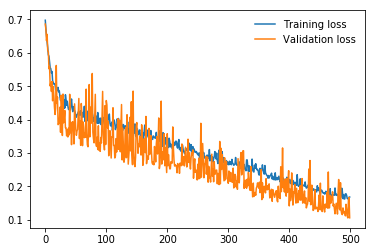

In [25]:
# Plot training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [26]:
# predict test data:
accuracy = 0
with torch.no_grad():    
    for i, (items, classes) in enumerate(test_loader):
        outputs = net(items)
        
        ps = torch.exp(outputs)

        top_p, top_class = ps.topk(1, dim=1)
        labels = classes.view(*top_class.shape)

        equals = top_class == labels
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
print(f'Accuracy: {accuracy/len(test_loader)*100}%')
print(f'Predicted Outcome:{top_class.view(*classes.shape)}')
print(f'Actual Outcome:{classes}')      

Accuracy: 98.0%
Predicted Outcome:tensor([0, 1, 0, 0])
Actual Outcome:tensor([0, 1, 0, 0])
